In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv

In [ ]:
data_path = '/home/gonzalez/Desktop/age_gender/age_gender.csv'
url = 'https://www.kaggle.com/code/shahraizanwar/age-gender-ethnicity-prediction/data?select=age_gender.csv'

In [ ]:
data = pd.read_csv(data_path)

In [ ]:
data.columns

# Loading data from google cloud to google colab

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/age_gender.csv')

 # Transforming the pixels data type into a list of float

In [ ]:
# images =[]
# for fotos in range(len(data['pixels'])):
#     X = data['pixels'][fotos].split(" ")
#     X = list(map(int, X))
#     images.append(X)

In [ ]:
# x = np.reshape(images[5000], (48,48))

In [ ]:
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [ ]:
blob = data['pixels'][0].reshape(48,48)

In [ ]:
plt.imshow(blob, cmap='gray');

In [ ]:
#sns.displot(data['ethnicity']),
#sns.displot(data['gender']), 
#sns.displot(data['age']);
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.histplot(ax=axes[0], x=data['age']);
sns.histplot(ax=axes[1], x=data['ethnicity']);
sns.histplot(ax=axes[2], x=data['gender']);

# Working with the age

In [ ]:
# list the number of counts per age
ages = data['age'].unique()
counts = []
for age in ages:
    counts.append(np.count_nonzero(data['age']==age))

In [ ]:
# table with the first 15 most dense samples regarding age
type(ages), type(counts)
s =pd.DataFrame([ages.T, np.array(counts).T],['ages', 'counts'])
s=s.transpose()
more_dense = s.sort_values(by=['counts'], ascending=False)
more_dense.head(15)

# create image manipulation funtions

In [2]:
import cv2
import sys, os

In [144]:
# get image
locattion = "/home/gonzalez/foto.jpg" # javier
#locattion = "/home/gonzalez/Paul.jpeg" # Paul
#locattion = "/home/gonzalez/Konstantine.jpeg"


#base_dir = os.path.dirname(locattion)
#image = cv2.imread("/home/gonzalez/foto.jpg")
#plt.imshow(image, cmap='gray');
#print(f'==> image resolution {image.shape}')

In [ ]:
# from PIL import Image           # this can be used to rotate images
# image = Image.open(locattion)
# image.

In [ ]:
# (h, w) = image.shape[:2]
# blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
# #blob.shape
# blob.shape

In [ ]:
# image face detection

In [145]:
imagePath=locattion
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=3,
    minSize=(30, 30)
)

print("[INFO] Found {0} Faces.".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0),1)
    roi_color = image[y:y + h, x:x + w]
    #print("[INFO] Object found. Saving locally.")
    #cv2.imwrite(str(w) + str(h) + '_faces.jpg', roi_color)

[INFO] Found 1 Faces.


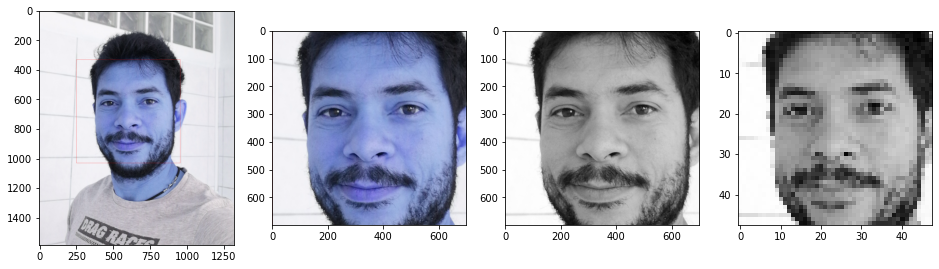

In [149]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,16))

ax1.imshow(image) # original image

ax2.imshow(roi_color) # recorted original image
roi_color.shape

img = np.mean(roi_color, axis=2) # black and white image
ax3.imshow(img, cmap='gray');

img=img[2:,2:]  # remove red line effect

res_final = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_LINEAR)
ax4.imshow(res_final, cmap='gray');


In [150]:
res_final.shape
res_final_ready = np.reshape(res_final, (-1, 48, 48,1))
res_final_ready.shape

(1, 48, 48, 1)

In [37]:
model = models.load_model('Model48')

In [20]:
# model.predict(res_final_ready)
# index = np.where(model.predict(res_final_ready)==(model.predict(res_final_ready).max()))
# index[1][0]

0

In [151]:
model = models.load_model('Model48')
int(model.predict(res_final_ready)[0][0])

#try_inp = np.expand_dims(X_test[n], axis=0)
#model.predict(try_inp)[0,0]

16

In [ ]:
# resize image

In [ ]:
# image conver to black and white
#image = cv2.imread(imagePath)
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function for transforming data numbers into data range classification

In [ ]:
# categorize age per range:
def age_categorize(input_list, age_step=10):
    '''
    Enter the list of age into input_list and the age steps
    with : age_step = 5;  age = 4   =>  1-5
                          age = 12  =>  10-15                        
    '''
    
    cat_age = []
    for age in input_list:
        
        a = float(age)/float(age_step)
        
        if a > 1:
            entero = int(a)
            coma = a-entero
            
            if coma > 0:
                entero = entero+1
            
            max = entero * age_step
            min = max-(age_step-1)     
            #cat_age.append(f'{min} to {max}')   # if the output is in the real intervale
            cat_age.append(int(max/age_step)-1)  # if the output is in categorical int number
        else:
            min = 1
            max = age_step
            #cat_age.append(f'{min} to {max}')    # if the output is in the real intervale   
            cat_age.append(int(max/age_step)-1)   # if the output is in categorical int number

            
    return cat_age

# Here we go with the model

In [7]:
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

2022-06-01 16:05:51.674858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gonzalez/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/cv2/../../lib64::/home/gonzalez/TOOLS/elmer/install//lib
2022-06-01 16:05:51.674881: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y = data['age']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen=ImageDataGenerator(rescale=1/255)
# train_generator_age=train_datagen.flow(
#     X_train ,y_train ,batch_size=32)

# test_datagen=ImageDataGenerator(rescale=1/255)
# test_generator_age=test_datagen.flow(
#     X_test ,y_test ,batch_size=32)

In [ ]:
def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

In [ ]:
model = initialize_model()
model.summary()

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='mae', patience=6, restore_best_weights=True)

# earlystop=EarlyStopping(patience=6)
# learning_rate_reduction=ReduceLROnPlateau(
#     monitor='val_acc',
#     patience= 3,
#     verbose=1,
# )
# callbacks = [earlystop, learning_rate_reduction]

In [ ]:
X_train.shape

In [ ]:
# history_age = model.fit(
#     train_generator_age, 
#     epochs= 60,
#     validation_data= test_generator_age,
#     callbacks= callbacks)

In [ ]:
history = model.fit(X_train, y_train, epochs=40, callbacks=[es])

In [ ]:
#history = model.fit(X, y, validation_split=0.3, epochs=100, callbacks=[es], batch_size=32)

In [ ]:
#history.__dict__

In [ ]:
plt.plot(history.history['loss']);
plt.plot(history.history['mae']);

In [ ]:
# models.save_model(model, 'Model48')
model = models.load_model('Model48')

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
n=3847
plt.imshow(X[n], cmap='gray');
y_test.iloc[n]

In [ ]:
#out= model.predict(X_test)
try_inp = np.expand_dims(X_test[n], axis=0)
model.predict(try_inp)[0,0]

In [ ]:
np.shape(X[0])

# MODEL USING DATA BUCKET

In [ ]:
step_size = 5
input_list = data['age']
cat = age_categorize(input_list, step_size)
#pd.DataFrame(cat, data['age'].values).sample(100)

In [ ]:
# add categorical age clasification to original dataframe
data['class_age']=cat
#data[['age','class_age']].sample(10)

In [ ]:
sns.histplot(data['class_age']);

In [ ]:
# data preparation
#data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
#X = data['pixels'].tolist()
#X = np.reshape(X, (-1, 48, 48,1))

y=data['class_age']

In [ ]:
# perform one-hot encoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
ohe.fit(data[['class_age']])
class_age_encoded = ohe.transform(data[['class_age']])

In [ ]:
for elements in range(class_age_encoded.shape[1]):
    data[str(elements)]=class_age_encoded[:,elements]

In [ ]:
y=data.drop(columns=['age','ethnicity','gender', 'img_name', 'pixels', 'class_age'])

In [ ]:
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
y.shape[1]

In [ ]:
def initialize_model_catgorical():
        
    model = Sequential()
    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu',input_shape=(48,48,1)))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(32,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(64,(3,3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
   
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))


    model.add(layers.Dense(24, activation='softmax'))   
    return model

In [ ]:
model = initialize_model_catgorical()
#model = initialize_model_catgorical()

model.summary()

In [ ]:
model.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='accuracy', patience=6, restore_best_weights=True)

In [ ]:
history_cat = model.fit(X_train,y_train, epochs=50, callbacks=[es])

In [ ]:
history = model.fit(X, y, validation_split=0.3, epochs=20, callbacks=[es], batch_size=32)  # the best

In [ ]:
plt.plot(history.history['val_accuracy']);
plt.plot(history.history['accuracy']);

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
n=2134
plt.imshow(X_test[n], cmap='gray');
np.where(y_test.iloc[n]==1)[0]

In [ ]:
try_inp = np.expand_dims(X_test[n], axis=0)
model.predict(try_inp).max()
index = np.where(model.predict(try_inp)==(model.predict(try_inp).max()))
index[1][0]

# best results using colab with regression on virgen data

In [ ]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import csv

from google.colab import drive 
drive.mount('/content/gdrive')
data=pd.read_csv('gdrive/My Drive/age_gender.csv')

data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

X = data['pixels'].tolist()
X = np.reshape(X, (-1, 48, 48,1))

y = data['age']


def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
   
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))          

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='relu'))
   
    return model

model = initialize_model()
model.summary()

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

history = model.fit(X_train, y_train, epochs=100, callbacks=[es])

plt.plot(history.history['loss']);
plt.plot(history.history['mae']);

n=5
out = np.reshape(X_test[n], (48, 48))
plt.imshow(out, cmap='gray');
y_test.iloc[n]

try_inp = np.expand_dims(X_test[n], axis=0)
model.predict(try_inp)[0,0]